# Пайплайн обучения в PyTorch
В этой тетрадке мы соберем полный пайплайн обучения классификатора на основе нейросети.
На примере небольшого датасета мы увидим, как строить и обучать модели в PyTorch, и закрепим наши знания про слои.
## Классификация картинок
Задачу классификации будем решать по уже знакомому пайплайну:
- постановка задачи;
- определимся с метриками;
- соберем данные;
- построим бейзлайн, обучим его;
- проверим качество бейзлайна;

Бейзлайн мы построим на известных нам слоях: Linear и нелинейности.

### Постановка задачи и метрики
Требуется научиться классифицировать изображения английских букв от A до J.
Изображения имеют фиксированный размер 28x28 пикселей, черно-белые.

В качестве финальной метрики бизнес интересует **accuracy** - точность распознавания класса.

### Данные
Для обучения и валидации будем использовать датасет [notMNIST](https://www.kaggle.com/datasets/lubaroli/notmnist), который можно скачать по [ссылке](http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz).

#### Как хранятся картинки в памяти компьютера
Компьютер хранит картинку в памяти как набор точек (_пикселей_).
Каждый пиксель - это квадрат одного цвета.
Пиксели достаточно маленькие, поэтому глаз не замечает, что изображение состоит из квадратов.

В черно-белых изображениях пиксель представляет из себя одно чило - интенсивность белого цвета. 0 - это черный цвет, 255 - белый, посередине - оттенки серого.

В цветных изображениях пиксель - это набор из трех чисел: (R, G, B). R - интенсивность красного цвета, G - интенсивность зелёного цвета, B - синего.
Числа тоже в диапазоне от 0 до 255 (обычно).

В нашем датасете только ч/б изображения, поэтому каждая картинка будет представлять из себя матрицу (28, 28) - 28 пикселей в ширину и 28 в высоту.

In [1]:
import http.client
import tarfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

# Зафиксируем все seed для воспроизводимости
seed = 0
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
def prepare_data():
    """Скачивает данные и распаковывает их."""
    target_file = "notMNIST_small.tar.gz"
    if Path(target_file).exists():
        print("Файл уже загружен, не загружаю снова")
    else:
        conn = http.client.HTTPConnection("yaroslavvb.com", 80)
        conn.request("GET", "/upload/notMNIST/notMNIST_small.tar.gz")
        data = conn.getresponse().read()
        with open(target_file, "wb") as f:
            f.write(data)
    with tarfile.open(target_file) as f:
        f.extractall()
    print("Данные были скачены и распакованы")


def read_notmnist_data(
    data_dir: str = "notMNIST_small",
) -> tuple[np.ndarray, np.ndarray]:
    """Прочитать картинки датасета notMNIST и положить их в numpy-массив.

    :returns: пару numpy-массивов (изображения, соответствующие метки)
    """
    images, labels = [], []
    for img_path in Path(data_dir).glob("**/*.png"):
        # Имя папки - это метка класса
        img_label = img_path.parts[1]
        try:
            image = plt.imread(img_path)
        except SyntaxError:
            print(
                f"Изображение не читается по пути {img_path} (это ок, но таких должно быть < 10)"
            )
            continue
        labels.append(img_label)
        images.append(image)
    return np.stack(images, axis=0), np.stack(labels, axis=0)


prepare_data()
X, y = read_notmnist_data()
assert X.shape[0] == y.shape[0]
print()
print("Размеры данных:", X.shape, y.shape)
print(f"Пример класса: {y[0]}")
# видим, что метки - это буквы, закодируем их числами
ohe = LabelEncoder()
y = ohe.fit_transform(y)

Файл уже загружен, не загружаю снова
Данные были скачены и распакованы
Изображение не читается по пути notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png (это ок, но таких должно быть < 10)
Изображение не читается по пути notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png (это ок, но таких должно быть < 10)

Размеры данных: (18724, 28, 28) (18724,)
Пример класса: B


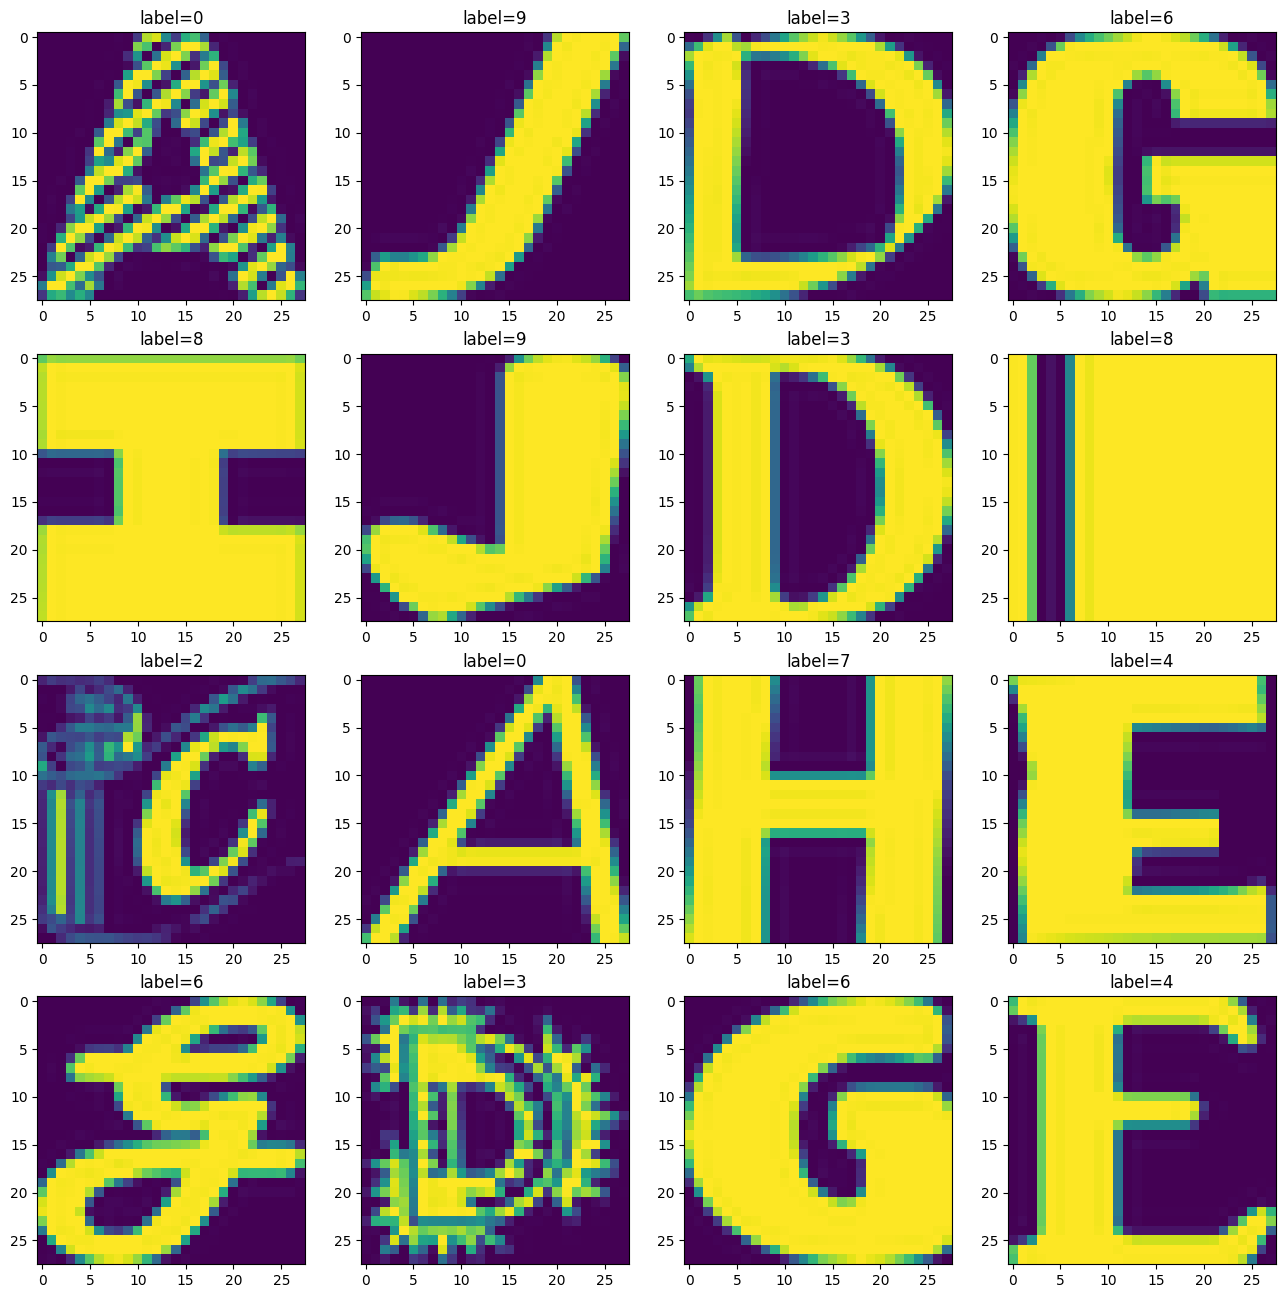

In [3]:
# Данных много, можно поделить на train/val/test
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=seed
)
# Посмотрим на данные глазами
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for row in range(4):
    for col in range(4):
        idx = 4 * row + col
        ax[row][col].imshow(X_train[idx])
        ax[row][col].set_title(f"label={y_train[idx]}")

### Строим бейзлайн
В качестве простой модели попробуем несколько линейных слоев и нелинейностей.
#### Создаем модель

In [4]:
# Нейросети объявляются через класс, который наследуется от torch.nn.Module
# Внутри класса нужно реализовать метод forward: в нем прописано, что сеть делает с тензором
class SimpleModel(nn.Module):
    # В __init__ объявим все слои, которые нам нужны
    def __init__(self, num_classes: int):
        super().__init__()

        # NOTE: Linear принимает (N, C), картинки заданы как (N, W, H) - придется менять форму, держим в уме.
        # Будем из 28 * 28 переводить в 256
        hidden_dim = 256
        self.linear_1 = nn.Linear(in_features=28 * 28, out_features=hidden_dim)

        # Нелинейность иногда называют активацией. Мы возьмем ReLU(x) = max(x, 0)
        self.act_1 = nn.ReLU()

        # Второй линейный слой, принимать будет выход из первого
        self.linear_2 = nn.Linear(in_features=hidden_dim, out_features=num_classes)

        # Softmax выдает числа от 0 до 1, которые в сумме дают 1 - идеально для классификации
        self.act_2 = nn.Softmax(dim=1)
        # NOTE: какой выход куда пойдет - это будет прописано в forward

    def forward(self, x: torch.Tensor):
        # В этом методе нужно сделать все преобразования над тензором.
        # Мы сначала поменяем форму, как это требует linear_1
        x = x.reshape((-1, 28 * 28))
        # Потом последовательно применим все слои
        for one_transform in (self.linear_1, self.act_1, self.linear_2, self.act_2):
            x = one_transform(x)
        return x


# Полезно всегда проверить, что сеть может прогнать ваши данные.
model = SimpleModel(num_classes=len(ohe.classes_))
# PyTorch модели не умеют работать с numpy-массивами, только с torch.Tensor.
# Конвертируем через torch.from_numpy
some_output = model(torch.from_numpy(X_train[[0]]))
some_output

tensor([[0.1008, 0.0894, 0.0947, 0.1067, 0.0997, 0.0928, 0.1034, 0.1029, 0.1097,
         0.0999]], grad_fn=<SoftmaxBackward0>)

Таким образом, чтобы объявить сеть в PyTorch, нужно:
- создать класс, наследующийся от `nn.Module`;
- в методе `forward(self, x)` прописать, сколько тензоров сеть принимает и что с ними нужно сделать;
- в конструкторе (метод `__init__`) объявить все необходимые слои, вызвав `super().__init__()` в начале;

Желательно также прогнать созданную сеть над примером данных - чтобы убедиться, что все работает.

##### Про градиент
Обратите внимание: у выхода сети есть `grad_fn`.
Это неспроста: мы использовали все слои из `torch.nn`, поэтому PyTorch сумел **самостоятельно** разобраться, как считать градиент по всем слоям и всем параметрам.
Нам не нужно расписывать формулы и считать градиенты - это делает автоматика!

In [5]:
# Давайте убедимся в этом: подсчитаем функцию потерь и попросим от нее градиент.
# Будем использовать Cross Entropy в качестве функции потерь - хороший вариант для задачи классификации.
import torch.nn.functional as F

loss = F.cross_entropy(some_output, torch.from_numpy(y[[0]]))
print(loss)
# Хм, а реально ли градиенты все сами подсчитаются? Посмотрим
print(model.linear_1.weight.grad)
# Градиента нет - мы лишь прогнали данные через модель

tensor(2.3132, grad_fn=<NllLossBackward0>)
None


In [6]:
# Теперь просим подсчитать градиент и распространить его назад по всем слоям
loss.backward()
# Смотрим на градиент
print(model.linear_1.weight.grad)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0026, 0.0018, 0.0004],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


Градиент появился. Когда мы вызвали `loss.backward()`, PyTorch сделал сделал следующее:
1. Подсчитал напрямую производую лосса $L = -\sum\limits_{c=1}^M y_c \log p_c$ по $p_c$.
2. Отследил цепочку преобразований, через которую получился этот $p_c$ - вероятность каждого класса.
3. Прошелся по этой цепочке с конца в начало, применил chain rule и подсчитал градиент по каждому из обучаемых параметров.
4. Записал этот градиент в тензоры weight и bias каждого слоя, чтобы не забыть.

И все это произошло "под капотом" одной функции: `loss.backward()` - чудеса!

#### Обучаем модель
Окей, мы собрали данные, построили модель, выбрали функцию потерь, научились считать градиент по всем параметрам модели.
Дело осталось за малым - пройтись градиентным спуском по данным и оптимизировать параметры.

PyTorch делает четкое разделение: модели в одном месте, алгоритм спуска - в другом.
Более того, сам спуск вам понадобится написать вручную - не бойтесь, это несложно.

In [7]:
# Преобразуем все данные в torch.Tensor, чтобы не вызывать везде torch.from_numpy
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_val, y_val = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)

In [8]:
import tqdm

# все методы оптимизации лежат в torch.optim
from torch.optim.sgd import SGD

"""
Для "обучения" модели есть модуль torch.optim - в нем инструменты для обучения параметров.
Сегодня мы будем использовать Стохастический Градиентный Спуск - Stohastic Gradient Descent.
Стохастичности у нас не будет: мы "скормим" все данные модели сразу (они маленькие, это сработает).

Optimizer работает так:
- вы говорите ему, какие параметры в его зоне ответственности;
- затем вы говорите ему, что пришло время сделать шаг спуска;
- optimizer проходит по всем параметрам, за которые отвечает, берет их градиент и что-то с ним делает;
- что именно делает - зависит от конкретного оптимизатора;

Конкретно SGD делает обновление весов по формуле w <- w - eta * gradient.
Это обычный градиентный спуск.
Есть более продвинутые алгоритмы (Adam, RMSprop), с ними познакомимся позже.
"""
# создаем optimizer и говорим "ты отвечаешь за все параметры модели"
optimizer = SGD(params=model.parameters(), lr=1e-1)
# model.parameters() возвращает все обучаемые параметры модели (в виде тензоров).
# Откуда функция все эти параметры узнает, ведь мы нигде их явно не прописывали в классе модели?
# Это магия PyTorch, он умеет многое делать сам :)


def train_model(model: nn.Module, optimizer: SGD, x: torch.Tensor, y: torch.Tensor):
    losses = []
    # Пройдемся 2000 раз по всем данным
    for _ in tqdm.trange(2_000):
        # optimizer по умолчанию "помнит" градиенты с прошлых итераций - и прибавляет к новым.
        # Так сделано ради продвинутых техник обучения.
        # Нам это не надо, поэтому в каждой итерации явно зануляем все градиенты - пусть считаются заново.
        optimizer.zero_grad()

        # Это блок уже знаем: считаем выход, потери, градиенты по потерям.
        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()

        # Просим оптимизатор пройтись по параметрам и сделать градиентный спуск.
        # Оптимизатор сам обновит веса, вручную этого делать не надо
        optimizer.step()

        # Запомним loss
        losses.append(loss.detach().item())
    return losses


losses = train_model(model, optimizer, X_train, y_train)

100%|██████████| 2000/2000 [00:35<00:00, 55.98it/s]


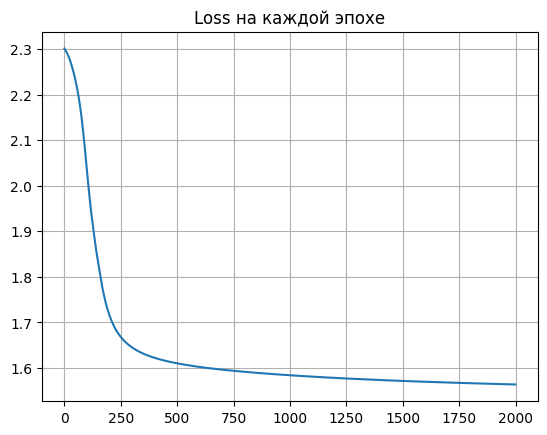

In [9]:
# Посмотрим, действительно ли модель училась
def plot_losses(losses: list[float]):
    plt.plot(losses)
    plt.title("Loss на каждой эпохе")
    plt.grid()
    plt.show()


plot_losses(losses)

In [10]:
# А что по качеству?
def accuracy(model: SimpleModel, x: torch.Tensor, y: torch.Tensor):
    return torch.sum(torch.argmax(model(x), dim=1) == y) / len(y)


print(f"accuracy на train данных: {accuracy(model, X_train, y_train)}")
print(f"accuracy на val данных: {accuracy(model, X_val, y_val)}")
print(f"accuracy на test данных: {accuracy(model, X_test, y_test)}")

accuracy на train данных: 0.909705400466919
accuracy на val данных: 0.8908544778823853
accuracy на test данных: 0.8998664617538452


Получилось весьма неплохо.

В нашем решении есть большой простор для улучшений:
- использовать AdaM вместо SGD;
- добавить больше слоев;
- попробовать новые слои (в следующем уроке пополним наш арсенал);

Как грамотно попробовать идеи и не потерять рабочий результат - узнаем на следующем уроке.

#### Резюме
1. Узнали, что картинки хранятся в компьютере как матрица, каждый ее элемент описывает интенсивность цвета.
2. Научились создавать нейросеть через класс, наследующийся от `nn.Module`.
3. Научились прогонять данные через нейросеть, считать функцию потерь и градиенты по всем параметрам.
4. Познакомились с оптимизаторами (_optimizer_), с их помощью обучили нейросеть, используя SGD.
5. Посчитали метрику качества обученной модели, получили рабочий бейзлайн.

## Регрессия: предсказываем экономичность автомобиля
_Вдохновлено [туториалом из TensorFlow](https://www.tensorflow.org/tutorials/keras/regression)._

Посмотрим, как можно в PyTorch решать задачу регрессии.
Решать ее будем по тому же пайплайну, а именно:

1. Будем предсказывать расход топлива на километр для автомобиля по его характеристикам.
2. В качестве метрики качества будем использовать MSE и MAPE.
3. Данные возьмем из датасета [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg).
Этот датасет содержит фичи автомобилей и их MPG (Miles Per Gallon) - сколько миль (1609 метров) можно проехать за один галлон топлива (4.55 литров).
В пересчете на наши единицы 1 MPG = 0.354 км/л.
4. Бейзлайн возьмем такой же, как в классификации, только поменяем последний слой - вместо 10 классов будет предсказывать одно число.
5. Качество померим по MSE, учить тоже будем на MSE.

В этом примере мы посмотрим:
- как справится AdaM с обучением сети;
- как использовать функции потерь регрессии в PyTorch;
- как использовать GPU во время обучения.

In [11]:
# Подготовим данные
import pandas as pd

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]

raw_dataset = pd.read_csv(
    url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)


def process_data(raw_dataset: pd.DataFrame):
    """Подготовить данные.

    Удаляет пропуски, кодирует категории, бьет на train/test, нормирует численные признаки.
    Возвращает фичи и таргеты для train и test.
    """
    dataset = raw_dataset.copy()
    dataset = dataset.dropna()

    # Сделаем OHE на Origin
    dataset["Origin"] = dataset["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})
    dataset = pd.get_dummies(dataset, columns=["Origin"])

    # Разобьем на train/test
    train_dataset = dataset.sample(frac=0.8, random_state=seed)
    test_dataset = dataset.drop(train_dataset.index)

    # Нормируем числа (статистики берем из train-датасета)
    mean = train_dataset.describe().transpose()["mean"]
    std = train_dataset.describe().transpose()["std"]
    for dataset in (train_dataset, test_dataset):
        dataset[mean.index] = (dataset[mean.index] - mean) / std

    # Уберем target из фичей
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()
    train_target = train_features.pop("MPG")
    test_target = test_features.pop("MPG")

    return train_features, test_features, train_target, test_target


train_features, test_features, train_target, test_target = process_data(raw_dataset)
train_features.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Europe,Origin_Japan,Origin_USA
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,False,False,True
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,False,False,True
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,False,True,False
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,False,True,False
182,-0.869348,-0.846517,-0.495310,-0.623596,-0.021237,0.027726,True,False,False


In [12]:
# Модель возьмем ту же, что в прошлом примере
class RegressionModel(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        hidden_dim = 256
        # Для разнообразия засунем все в nn.Sequential
        self.transform = nn.Sequential(
            # Теперь на вход приходит другое число фичей
            nn.Linear(in_features=num_features, out_features=hidden_dim),
            nn.ReLU(),
            # Единственное отличие: out_features=1, предсказываем 1 число - наш таргет
            nn.Linear(in_features=hidden_dim, out_features=1),
            # Предсказываем число в произвольном диапазоне, поэтому нелинейность убираем
            # self.act_2 = nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor):
        # .squeeze(1) "съест" лишнюю размерность: (N, 1) -> (N, )
        return self.transform(x).squeeze(1)
    
reg_model = RegressionModel(num_features=len(train_features.columns))
reg_model(torch.from_numpy(train_features.to_numpy(dtype="float32")[[0]]))

tensor([-0.1352], grad_fn=<SqueezeBackward1>)

In [13]:
# Перед обучением все переведем в torch.Tensor
t_train_features = torch.from_numpy(train_features.to_numpy(dtype="float32"))
t_test_features = torch.from_numpy(test_features.to_numpy(dtype="float32"))
t_train_target = torch.from_numpy(train_target.to_numpy(dtype="float32"))
t_test_target = torch.from_numpy(test_target.to_numpy(dtype="float32"))

In [14]:
# Adam лежит в том же torch.optim
from torch.optim.adam import Adam


# Такую строку вы часто будете встречать в других кодах :)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Используем", device)

# Создаем оптимайзер
reg_optimizer = Adam(params=reg_model.parameters())

# Перед началом обучения разместим модель на нужном устройстве
reg_model = reg_model.to(device)
# Оптимизатор не надо на устройство переносить

# И идем учиться, 3000 эпох
# Данных мало, так что сразу на всех их будем учиться
reg_losses = []
for _ in tqdm.trange(3000):
    # Не забываем обнулить градиенты
    reg_optimizer.zero_grad()

    # Переносим новый батч на GPU
    # Вообще, раз учимся на всех данных, можно было 1 раз перенести на GPU, а не в цикле
    # Но в реальной ситуации будут разные данные на каждой итерации
    batch_x = t_train_features.clone().to(device)
    batch_y = t_train_target.clone().to(device)

    # Считаем выход, лосс, градиенты - и делаем шаг
    output = reg_model(batch_x)
    # MSE loss лежит в том же месте, где cross_entropy
    # И используется точно так же
    loss = F.mse_loss(output, batch_y)
    loss.backward()
    reg_optimizer.step()

    # .cpu() перенесет loss на ЦПУ, .item() вернет как число
    reg_losses.append(loss.cpu().item())

Используем cuda


100%|██████████| 3000/3000 [00:02<00:00, 1261.27it/s]


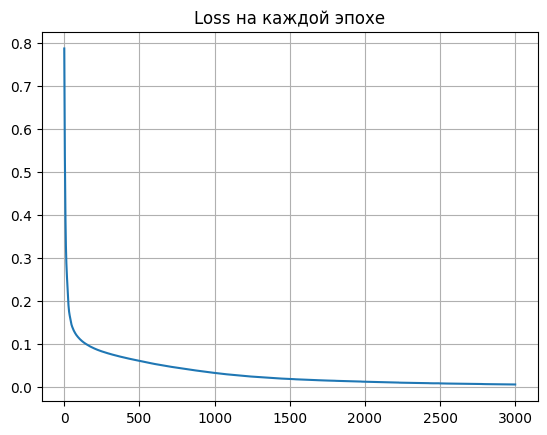

In [15]:
plot_losses(reg_losses)

In [16]:
# Считаем финальную метрику на тестовых данных
with torch.no_grad():
    # Помним, что все тензоры должны быть на одном устройстве
    out = reg_model(t_test_features.to(device)).cpu()
    mse_loss = F.mse_loss(out, t_test_target).item()
    # MAPE нету в F, придется руками делать
    mape_loss = torch.mean(
        # clamp обрезает все значения тензора с двух концов.
        torch.abs(out - t_test_target) / torch.clamp(torch.abs(out), min=1e-7)
    ).item()
    print("Финальный MSE-лосс:", mse_loss)
    print("Финальный MAPE-лосс:", mape_loss)

Финальный MSE-лосс: 0.14863716065883636
Финальный MAPE-лосс: 0.692229151725769


In [17]:
# Насколько это хорошо? Посмотрим на дисперсию таргета
raw_dataset["MPG"].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: MPG, dtype: float64

Ошибка в несколько раз меньше дисперсии.
Выходит, модель хорошо предсказывает таргет.

## Резюме ноутбука
1. Научились решать задачи классификации и регрессии на PyTorch.
2. Посмотрели, какие метрики качества есть в PyTorch для обеих задач и как их использовать.
3. Потрогали Adam и SGD, увидели их в деле.
4. Построили две сети с использованием Linear, ReLU и Sigmoid слоев.
5. Обучили две сети, убедились в хорошем качестве.
6. Научились работать с GPU в рамках пайплайна.